In [1]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from torchvision.utils import save_image, make_grid

from transformers import CLIPModel

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-27 11:51:01.480491: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 11:51:01.531893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-27 11:51:02.558212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist

## Данные и модель

In [2]:
from dataset import ArchDataset, GS_NEGATIVE_PATHS, GS_POSITIVE_PATHS, GS_NEGATIVE_COORDS, GS_POSITIVE_COORDS

In [3]:
from model import VQVAE

In [4]:
true_anomaly_indices = [
    0, 4, 9, 10, 11, 14, 15, 16, 17, 21, 26, 27, 30, 32, 33, 35, 37,
    40, 48, 49, 53, 58, 59, 62, 65, 68, 69, 72, 75, 76,
    80, 88, 89, 91, 98, 99, 101, 102, 105, 108, 113, 114, 116,
    128, 131, 136, 139, 141, 161
]

GS_DIR = '/home/jupyter/datasphere/datasets/sasgis-dataset-100k/google_satellite_data'

GS_DEFINITE_POSITIVE_PATHS = sorted([
    f'{GS_DIR}/positive_samples/{s}'
    for s in os.listdir(f'{GS_DIR}/positive_samples') 
    if s.endswith('.jpeg')
    and int(s.split('.')[0]) in true_anomaly_indices
])

GS_DEFINITE_POSITIVE_COORDS = [
    (lat, lon) 
    for i, (iid, _, _, lon, lat, _, _, _, _, _, _, _) 
    in pd.read_csv(f'{GS_DIR}/Eastern_desert_archaeological_structures_NEW.csv').iterrows()
    if i in true_anomaly_indices
]

len(GS_DEFINITE_POSITIVE_PATHS), len(GS_DEFINITE_POSITIVE_COORDS)

(49, 49)

# Параметры модели и обучения

In [5]:
EMBED_DIM = 16
NUM_EMBEDS = 8

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
results_dir = f'../vq_vae_training_sasgis_results/v2_256pix_gray_{str(EMBED_DIM).zfill(2)}embdim_{str(NUM_EMBEDS).zfill(2)}embeds'
res_img_path = f'v2_256pix_gray_{str(EMBED_DIM).zfill(2)}embdim_{str(NUM_EMBEDS).zfill(2)}embeds'
checkpoint_path = f'{results_dir}/checkpoint_9.pth'

In [8]:
anomaly_scores_dir = f'results_newvit_v2_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}'
os.mkdir(anomaly_scores_dir)

In [9]:
params = {
    'batch_size': 256,
    'img_size': 256,
    'channels': 1,
    'embedding_dim': EMBED_DIM,
    'num_embeddings': NUM_EMBEDS,
    'beta': 0.25,
    'n_epochs': 10,
}

# Датасет

In [10]:
transform_nocrop_256_grayscale = transforms.Compose([
    # transforms.CenterCrop((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [11]:
torch.manual_seed(42);

In [12]:
train_dataset = ArchDataset(
    img_paths=GS_NEGATIVE_PATHS, 
    coords=GS_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_nocrop_256_grayscale
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)

anomalies_dataset = ArchDataset(
    img_paths=GS_POSITIVE_PATHS, 
    coords=GS_POSITIVE_COORDS, 
    anomalies=True, 
    transform=transform_nocrop_256_grayscale
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

definite_anomalies_dataset = ArchDataset(
    img_paths=GS_DEFINITE_POSITIVE_PATHS, 
    coords=GS_DEFINITE_POSITIVE_COORDS, 
    anomalies=True, 
    transform=transform_nocrop_256_grayscale
)
definite_anomalies_loader = DataLoader(definite_anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [13]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')
print(f'definite anomalies: {len(definite_anomalies_dataset)} images, {len(definite_anomalies_loader)} batches')

train: 99254 images, 388 batches
anomalies: 165 images, 1 batches
definite anomalies: 49 images, 1 batches


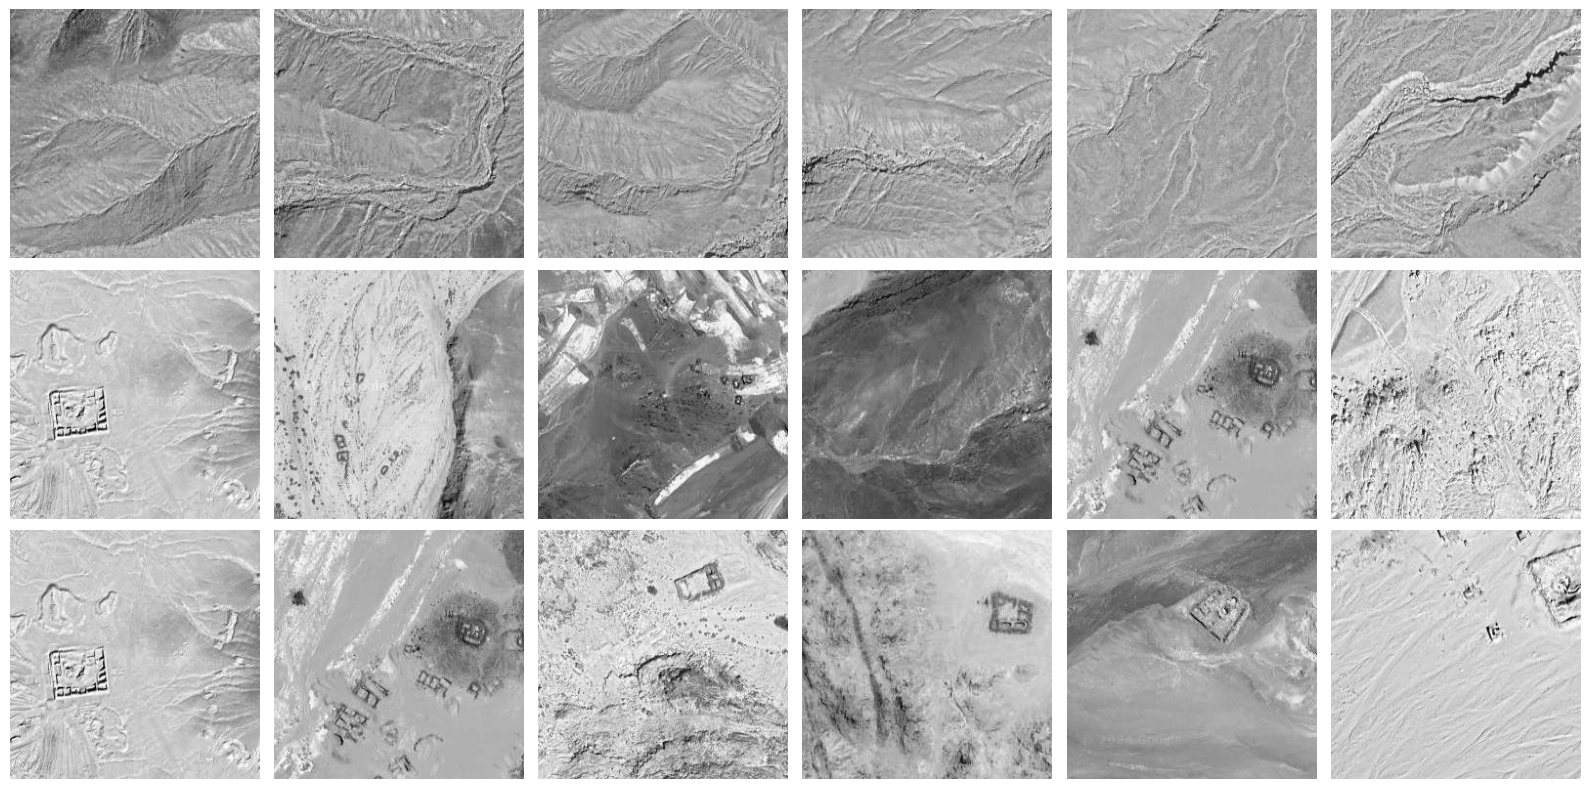

In [14]:
ncols = 6

fig, axs = plt.subplots(nrows=3, ncols=ncols, figsize=(16, 8))

# for row_idx, (row_axs, title) in enumerate(zip(axs, ['train', 'anomalies', 'definite_anomalies'])):
#     row_axs[0].set_title(title, y=1.2, fontsize=12, pad=20)  # y positions title above the row
#     for ax in row_axs:
#         ax.axis('off')

for i in range(ncols):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')    
    axs[0, i].imshow(train_dataset[i][0].permute(1, 2, 0), cmap='gray')
    axs[1, i].imshow(anomalies_dataset[i][0].permute(1, 2, 0), cmap='gray')
    axs[2, i].imshow(definite_anomalies_dataset[i][0].permute(1, 2, 0), cmap='gray')
    
fig.tight_layout()
fig.show()

# Модель, восстанавливающая изображения

In [15]:
model = VQVAE(
    in_channels=params['channels'],
    img_size=params['img_size'],
    
    embedding_dim=params['embedding_dim'],
    num_embeddings=params['num_embeddings'],
    beta=params['beta']
)
model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval();

# Utils

In [16]:
def load_image(names):
    imgs = []
    for name in names:
        img = transform_nocrop_256_grayscale(Image.open(name).convert('RGB'))
        imgs.append(img)
    return imgs

def align_image(img):
    return (img - img.min()) / (img.max() - img.min())

def draw_image(imgs):
    fig, axes = plt.subplots(ncols=len(imgs) , figsize=(len(imgs) * 2, 2))

    if len(imgs) == 1:
        img = imgs[0]
        axes.imshow(align_image(img).permute(1, 2, 0))
    else:
        for i, img in enumerate(imgs): 
            axes[i].imshow(align_image(img).permute(1, 2, 0))
    plt.show()

# Вычисление anomaly score

In [17]:
MODEL_NAME = 'openai/clip-vit-large-patch14'

clip_model = CLIPModel.from_pretrained(MODEL_NAME)
clip_model.to(device)
clip_model.eval();

In [18]:
clip_input_processor = transforms.Compose([
    transforms.Resize(224, antialias=False),
])

clip_rgb_input_processor = transforms.Compose([
    transforms.Normalize(mean=[0.4815, 0.4578, 0.4082], std=[0.2686, 0.2613, 0.2758]),
])

In [19]:
def extract_features(imgs):

    imgs = imgs.to(device)
    inputs = torch.stack([clip_input_processor(img) for img in imgs])
    inputs = torch.cat([inputs, inputs, inputs], dim=1)
    inputs = torch.stack([clip_rgb_input_processor(img) for img in inputs])    
    
    with torch.no_grad():
        outputs = clip_model.get_image_features(inputs)

    features = outputs
    return features

In [20]:
def compute_anomaly_scores(data_loader, limit_batches=None):

    limit_batches = limit_batches if limit_batches is not None else len(data_loader)
    anomaly_scores_res = {}

    for batch_idx, batch in tqdm(enumerate(data_loader), total=limit_batches):
        
        if limit_batches and batch_idx >= limit_batches:
            break
        
        images, indices, _, _ = batch
        images = images.to(device)
        indices = indices.cpu().tolist()
        
        with torch.no_grad():
            restored_images, _, _ = model(images)

        feat_original = extract_features(images)
        feat_restored = extract_features(restored_images)
        
        cosine_sim = F.cosine_similarity(feat_original, feat_restored, dim=1)
        anomaly_scores_batch = (1 - cosine_sim).cpu().tolist()
        
        for (idx, score) in zip(indices, anomaly_scores_batch):
            anomaly_scores_res[idx] = score
            
    
    return anomaly_scores_res

In [21]:
definite_anomaly_scores = compute_anomaly_scores(definite_anomalies_loader)

100%|██████████| 1/1 [01:51<00:00, 112.00s/it]


In [23]:
anomaly_scores = compute_anomaly_scores(anomalies_loader)

In [ ]:
train_scores = compute_anomaly_scores(train_loader)

In [22]:
with open(f'{anomaly_scores_dir}/definite_anomalies.txt', 'w') as f:
    for idx, score in definite_anomaly_scores.items():
        f.write(f"{idx}\t{score}\n")

# with open(f'{anomaly_scores_dir}/anomalies.txt', 'w') as f:
#     for idx, score in anomaly_scores.items():
#         f.write(f"{idx}\t{score}\n")
        
# with open(f'{anomaly_scores_dir}/train.txt', 'w') as f:
#     for idx, score in train_scores.items():
#         f.write(f"{idx}\t{score}\n")

## Считываем и смотрим

In [23]:
definite_anomaly_scores = {}
with open(f'{anomaly_scores_dir}/definite_anomalies.txt', 'r') as f:
    for line in f.readlines():
        idx, score = line.strip().split()
        definite_anomaly_scores[int(idx)] = float(score)

anomaly_scores = {}
with open(f'{anomaly_scores_dir}/anomalies.txt', 'r') as f:
    for line in f.readlines():
        idx, score = line.strip().split()
        anomaly_scores[int(idx)] = float(score)
        
train_scores = {}
with open(f'{anomaly_scores_dir}/train.txt', 'r') as f:
    for line in f.readlines():
        idx, score = line.strip().split()
        train_scores[int(idx)] = float(score)

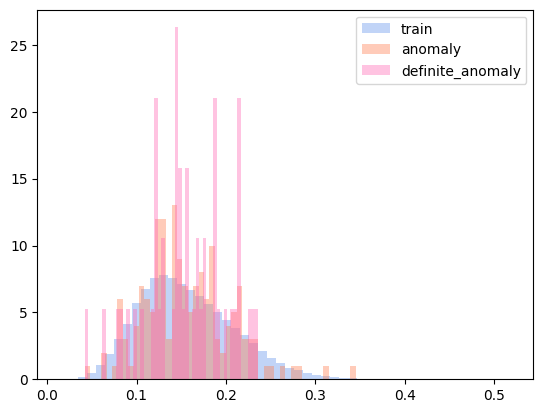

In [24]:
plt.hist(train_scores.values(), density=True, bins=50, alpha=0.4, label='train', color='cornflowerblue');
plt.hist(anomaly_scores.values(), density=True, bins=50, alpha=0.4, label='anomaly', color='coral');
plt.hist(definite_anomaly_scores.values(), density=True, bins=50, alpha=0.4, label='definite_anomaly', color='hotpink');

plt.legend();
plt.savefig(f'{anomaly_scores_dir}/newvit_hist_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}');

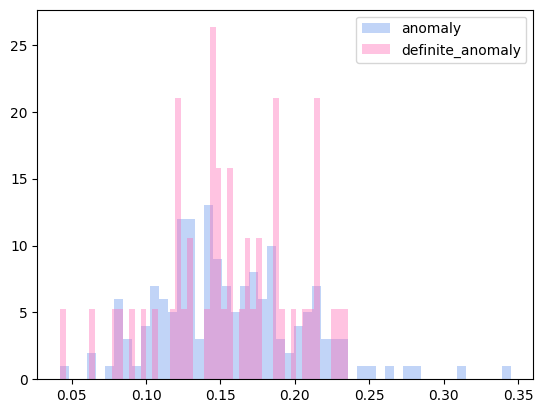

In [25]:
plt.hist(anomaly_scores.values(), density=True, bins=50, alpha=0.4, label='anomaly', color='cornflowerblue');
plt.hist(definite_anomaly_scores.values(), density=True, bins=50, alpha=0.4, label='definite_anomaly', color='hotpink');

plt.legend();
plt.savefig(f'{anomaly_scores_dir}/newvit_hist_2_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}');

In [26]:
anomaly_scores_np = np.array(sorted(anomaly_scores.values()))
train_scores_np = np.array(sorted(train_scores.values()))

# Метрики

In [27]:
definite_anomaly_scores_np = np.array(sorted(definite_anomaly_scores.values()))
anomaly_scores_np = np.array(sorted(anomaly_scores.values()))
train_scores_np = np.array(sorted(train_scores.values()))

## Сравнение со всеми аномалиями

In [28]:
y_true = np.array([1] * len(anomaly_scores_np) + [0] * len(train_scores_np))
y_scores = np.concatenate((anomaly_scores_np, train_scores_np), axis=0)
len(y_true), len(y_scores)

(99419, 99419)

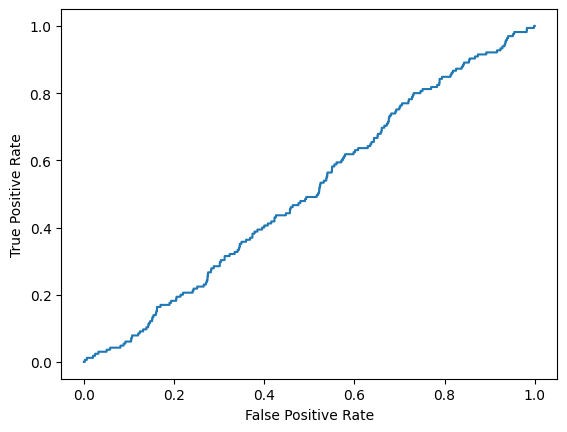

In [29]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.savefig(f'{anomaly_scores_dir}/newvit_roc_anomalies_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}');

In [30]:
precision_thresholds = np.array([0.80, 0.85, 0.90, 0.95])
thesholds = np.quantile(anomaly_scores_np, 1 - precision_thresholds)
percent_disproved = np.array([
    np.mean(train_scores_np < threshold)
    for threshold in thesholds
])

In [31]:
# сколько процентов данных отбрасываются из рассмотрения для фиксированного порого точности

for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
    print(f'precision {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%')
    
    
with open(f'{anomaly_scores_dir}/thresholds_anomalies.txt', 'w') as f:
    for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
        f.write(f'precision {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%\n')

precision 0.80 anomaly score threshold 0.12 result 26.58%
precision 0.85 anomaly score threshold 0.11 result 19.80%
precision 0.90 anomaly score threshold 0.10 result 14.49%
precision 0.95 anomaly score threshold 0.08 result 6.57%


## Сравнение с точно-аномалиями

In [32]:
y_true = np.array([1] * len(definite_anomaly_scores_np) + [0] * len(train_scores_np))
y_scores = np.concatenate((definite_anomaly_scores_np, train_scores_np), axis=0)
len(y_true), len(y_scores)

(99303, 99303)

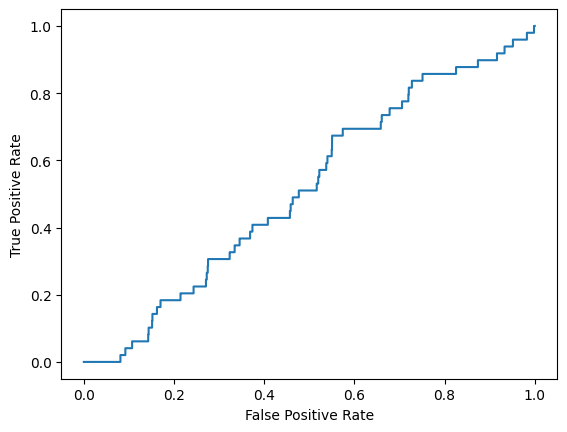

In [33]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.savefig(f'{anomaly_scores_dir}/newvit_roc_definite_anomalies_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}');

In [34]:
precision_thresholds = np.array([0.80, 0.85, 0.90, 0.95])
thesholds = np.quantile(definite_anomaly_scores_np, 1 - precision_thresholds)
percent_disproved = np.array([
    np.mean(train_scores_np < threshold)
    for threshold in thesholds
])

In [35]:
# сколько процентов данных отбрасываются из рассмотрения для фиксированного порого точности

for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
    print(f'precision {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%')
    
    
with open(f'{anomaly_scores_dir}/thresholds_definite_anomalies.txt', 'w') as f:
    for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
        f.write(f'precision {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%\n')

precision 0.80 anomaly score threshold 0.12 result 27.99%
precision 0.85 anomaly score threshold 0.12 result 25.35%
precision 0.90 anomaly score threshold 0.10 result 11.61%
precision 0.95 anomaly score threshold 0.08 result 5.51%
